# Assignment 3

## Part 1: Williams' Test Case

In [1]:
import os
import csv
import math
import numpy
from matplotlib import pyplot
from scipy import integrate
%matplotlib inline

### Loading the airfoil data

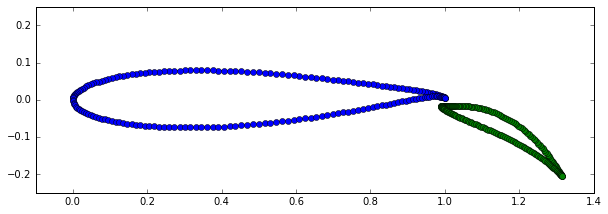

In [2]:
#importing the data of the airfoil and flap
filepath_main = os.path.join('.','MainFoil_N=200.csv')
filepath_flap = os.path.join('.','FlapFoil_N=200.csv')
with open(filepath_main) as file_name:
    reader = csv.reader(file_name, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x_main, y_main = zip(*reader)
    x_main = numpy.asarray(x_main)
    y_main = numpy.asarray(y_main)

with open(filepath_flap) as file_name:
    reader = csv.reader(file_name, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x_flap, y_flap = zip(*reader)
    x_flap = numpy.asarray(x_flap)
    y_flap = numpy.asarray(y_flap)
    
size = 10
pyplot.figure(figsize=(size,size))    
pyplot.plot(x_main,y_main,'-bo')
pyplot.plot(x_flap,y_flap,'-go')
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.4)
pyplot.ylim(-0.25,0.25);

### Defining panels for airfoil

In [3]:
class Panel:
    """
    Contains information pertaining to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [4]:
def define_panels(x,y):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    N = len(x)-1
    panels = numpy.empty(N,dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
    return panels

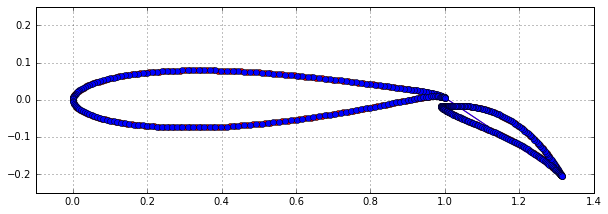

In [5]:
panels_main, panels_flap = define_panels(x_main,y_main), define_panels(x_flap,y_flap)
panels = numpy.concatenate((panels_main,panels_flap))

#plotting
size = 10
pyplot.figure(figsize=(size,size))
pyplot.grid()
pyplot.plot([panel.xa for panel in panels],[panel.ya for panel in panels],'-ro')
pyplot.plot([panel.xc for panel in panels],[panel.yc for panel in panels],'-bo')
pyplot.axis('scaled',adjustable='box')
pyplot.xlim(-0.1,1.4)
pyplot.ylim(-0.25,0.25);

### Freestream conditions

In [6]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees to radians

#creating freestream object
freestream = Freestream()

### Building linear system of equations

In [7]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk + (y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2 + (y - (panel.ya + numpy.cos(panel.beta)*s))**2))
    
    return integrate.quad(lambda s:integrand(s), 0.0, panel.length)[0]

In [8]:
def source_matrix(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
    return A

In [9]:
def vortex_matrix(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from other panels
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    return A

In [10]:
def build_matrix(panels):
    
    N = len(panels)                                      # no. of panels
    kutta = numpy.empty((2,N+2), dtype=float)            # initializing kutta condition matrix
    At = numpy.empty((N,N+2), dtype=float)               # initializing tangential contribution matrix
    main = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    flap = numpy.empty((N), dtype=float)                 # initializing source contribution on main airfoil tangential
    B = numpy.empty((N,2), dtype=float)                  # initializing vortex contribution matrix
    A = numpy.empty((N+2,N+2), dtype=float)              # initializing singularity matrix
    
    An = source_matrix(panels)
    Bn = vortex_matrix(panels)
    
    for i, panel_i in enumerate(panels):
        B[i,0] = numpy.sum(Bn[i,:N/2])
        B[i,1] = numpy.sum(Bn[i,N/2:])
    
    for i, panel_i in enumerate(panels):
        main[i] = numpy.sum(An[i,:N/2])
        flap[i] = numpy.sum(An[i,N/2:])
    
    At[:N,:N] = Bn
    At[:,-2] = -main
    At[:,-1] = -flap
    kutta[0,:] = At[0,:] + At[N/2-1,:]
    kutta[1,:] = At[N/2,:] + At[-1,:]
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, B, kutta
    
    return A, At

### Building the freestream rhs matrix

In [11]:
def build_freestream_rhs(panels, freestream):
    """Builds the right hand-side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: Numpy 1d array (float)
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf * (math.sin(freestream.alpha - panels[0].beta) + math.sin(freestream.alpha - panels[N/2-1].beta))
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf * (math.sin(freestream.alpha - panels[N/2].beta) + math.sin(freestream.alpha - panels[-1].beta))
    return b

### Solving the linear system of equations

In [12]:
A, At = build_matrix(panels)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A,b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma = strengths[-2:]

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

### Computing the pressure co-efficient

In [13]:
def compute_tangential_velocity(panels, freestream, gamma, At):
    N = len(panels)
    strengths = numpy.append([panel.sigma for panel in panels],gamma)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At,strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [14]:
def compute_pressure_coefficient(panels,freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [15]:
compute_tangential_velocity(panels,freestream,gamma,At)
compute_pressure_coefficient(panels,freestream)

### Assignment Questions

In [16]:
cp3main = panels[2].cp
cp10flap = panels[int(len(panels)/2+9)].cp
print('Q1. The pressure coefficient on the 3rd panel on the main airfoil is {}',format(cp3main))
print('Q2. The pressure coefficient on the 10th panel on the flap airfoil is {}',format(cp10flap))

Q1. The pressure coefficient on the 3rd panel on the main airfoil is {} -0.553530359707801
Q2. The pressure coefficient on the 10th panel on the flap airfoil is {} 0.26258053004679116


In [17]:
lift,drag = 0.,0.
for panel in panels:
    lift -= panel.cp*panel.length*numpy.sin(panel.beta)
    drag += panel.cp*panel.length*numpy.cos(panel.beta)
print('Q3. The lift on the airfoil is ',format(lift))
print('Q4. The drag on the airfoil is ',format(drag))

Q3. The lift on the airfoil is  3.7184339086812463
Q4. The drag on the airfoil is  0.0055835520558969245


In [18]:
lift_theo = 3.7386
err = abs(lift - lift_theo)
print('The error is ',format(err))

The error is  0.020166091318753576


In [20]:
err1 = 0.0408855231393          #the error when 100 panels were used
err_change = (err1-err)/err1*100
print('Q5. The improvement in the absolute error is ',format(err_change),'%')

Q5. The improvement in the absolute error is  50.67669490238339 %


In [22]:
gamma

array([ 0.67491043,  0.6179658 ])